In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sonar-folder/Cleaned_Nepali_dataset.csv
/kaggle/input/sonar-folder/X_train_embeddings.pt
/kaggle/input/sonar-folder/y_train_tensor.pt
/kaggle/input/sonar-folder/X_test_embeddings.pt
/kaggle/input/sonar-folder/y_test_tensor.pt


Using the best class weights for loss calculation obatined [at](https://www.kaggle.com/code/angeltamang/sonar-classifier-de/log)

In [2]:
filepath= "/kaggle/input/sonar-folder/Cleaned_Nepali_dataset.csv"
df= pd.read_csv(filepath)

# Setting up torch
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Setting default device to what's available
torch.set_default_device(device)

# The embeddings from SONAR
X_train_sonar= torch.load('/kaggle/input/sonar-folder/X_train_embeddings.pt')
X_test_sonar= torch.load('/kaggle/input/sonar-folder/X_test_embeddings.pt')
y_train_sonar= torch.load('/kaggle/input/sonar-folder/y_train_tensor.pt')
y_test_sonar= torch.load('/kaggle/input/sonar-folder/y_test_tensor.pt')

# Shape verification
print("X_train shape", X_train_sonar.shape)
print("X_test shape", X_test_sonar.shape)
print("y_train shape", y_train_sonar.shape)
print("y_test shape", y_test_sonar.shape)

Using cuda device


<ipython-input-2-c34111fe2a35>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_sonar= torch.load('/kaggle/input/sonar-folder/X_train_embeddings.pt')


X_train shape torch.Size([2287, 1024])
X_test shape torch.Size([572, 1024])
y_train shape torch.Size([2287])
y_test shape torch.Size([572])


<ipython-input-2-c34111fe2a35>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test_sonar= torch.load('/kaggle/input/sonar-folder/X_test_embeddings.pt')
<ipython-input-2

In [3]:
# Convert y_train_sonar and y_test_sonar to NumPy
y_train_np = y_train_sonar.cpu().numpy()
y_test_np = y_test_sonar.cpu().numpy()

# Create DataFrames
df_train = pd.DataFrame({'Original_Target': y_train_np})
df_test = pd.DataFrame({'Original_Target': y_test_np})

df_train.head()

,Original_Target
0,1
1,1
2,0
3,2
4,1


In [4]:
# Function maps both polarity of GENERAL, PROFANITY and VIOLENCE to single representation
def map_target(value):
    if value in [0, 1]:
        return 0 # GENERAL
    elif value in [2, 3]:
        return 1 # PROFANITY
    elif value in [4, 5]:
        return 2 # VOILENCE

# Mapping
df_train['Mapped_Target'] = df_train['Original_Target'].apply(map_target)
df_test['Mapped_Target'] = df_test['Original_Target'].apply(map_target)


In [5]:
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# Using new mapping
y_train_sonar_mapped = torch.tensor(df_train['Mapped_Target'].values, dtype=torch.long, device=device)
y_test_sonar_mapped = torch.tensor(df_test['Mapped_Target'].values, dtype=torch.long, device=device)

# Combine embeddings and labels into TensorDataset
train_dataset = TensorDataset(X_train_sonar, y_train_sonar_mapped)
test_dataset = TensorDataset(X_test_sonar, y_test_sonar_mapped)

# Concatenating train and test dataset
dataset = ConcatDataset([train_dataset, test_dataset])

dataset[0]

(tensor([ 0.0057, -0.0019, -0.0025,  ...,  0.0020, -0.0027, -0.0029]),
 tensor(0, device='cuda:0'))

In [6]:
# Now we continue building with our dataset

# Defining Network
import torch.nn as nn
import torch.optim as optim

# Defining neural network
class Sonar_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU, dropout= 0.5):
        super(Sonar_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialization
model= Sonar_Classifier(input_dim=1024, hidden_dim=222, output_dim=3, activation=nn.LeakyReLU, dropout=0.41566778988985065)
model.to(device= device)
print(model)

Sonar_Classifier(
  (fc1): Linear(in_features=1024, out_features=222, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.41566778988985065, inplace=False)
  (fc2): Linear(in_features=222, out_features=3, bias=True)
)


In [7]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay

# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Initialize the learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def model_train(model, criterion, optimizer, train_loader, test_loader, epochs=20):
  # Initialize lists to store training and testing losses
  train_losses = []
  test_losses = []

  # Training and evaluation loop
  for epoch in range(epochs):
      # Training phase
      model.train()
      train_loss = 0
      for X_batch, y_batch in train_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch.long())  # Ensure labels are long type
          loss.backward()
          # Prevent exploading gradients by clipping
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          train_loss += loss.item()
      train_loss /= len(train_loader)  # Average loss for training
      train_losses.append(train_loss)

      # Testing phase
      model.eval()
      test_loss = 0
      with torch.no_grad():
          for X_batch, y_batch in test_loader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
              outputs = model(X_batch)
              loss = criterion(outputs, y_batch.long())
              test_loss += loss.item()
      test_loss /= len(test_loader)  # Average loss for testing
      test_losses.append(test_loss)

      # # Update learning rate based on test loss
      # scheduler.step(test_loss)

      # Print losses for the epoch
      print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

  # Plot the learning curve
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Learning Curve')
  plt.legend()
  plt.grid()
  plt.show()

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set, generate a classification report, plot the ROC curve,
    and display the confusion matrix.

    Parameters:
        model: Trained PyTorch model
        test_loader: DataLoader for the test set

    Returns:
        None
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
            outputs = model(X_batch)  # Model predictions
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted classes

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Determine the number of classes
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # ROC Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()



Epoch 1/91, Train Loss: 1.0733, Test Loss: 1.0661
Epoch 2/91, Train Loss: 1.0523, Test Loss: 1.0562
Epoch 3/91, Train Loss: 1.0398, Test Loss: 1.0481
Epoch 4/91, Train Loss: 1.0318, Test Loss: 1.0402
Epoch 5/91, Train Loss: 1.0167, Test Loss: 1.0318
Epoch 6/91, Train Loss: 1.0047, Test Loss: 1.0232
Epoch 7/91, Train Loss: 0.9943, Test Loss: 1.0140
Epoch 8/91, Train Loss: 0.9810, Test Loss: 1.0060
Epoch 9/91, Train Loss: 0.9663, Test Loss: 0.9976
Epoch 10/91, Train Loss: 0.9563, Test Loss: 0.9903
Epoch 11/91, Train Loss: 0.9464, Test Loss: 0.9829
Epoch 12/91, Train Loss: 0.9321, Test Loss: 0.9765
Epoch 13/91, Train Loss: 0.9216, Test Loss: 0.9705
Epoch 14/91, Train Loss: 0.9159, Test Loss: 0.9651
Epoch 15/91, Train Loss: 0.9090, Test Loss: 0.9603
Epoch 16/91, Train Loss: 0.8977, Test Loss: 0.9547
Epoch 17/91, Train Loss: 0.8899, Test Loss: 0.9499
Epoch 18/91, Train Loss: 0.8825, Test Loss: 0.9454
Epoch 19/91, Train Loss: 0.8758, Test Loss: 0.9408
Epoch 20/91, Train Loss: 0.8675, Test Lo

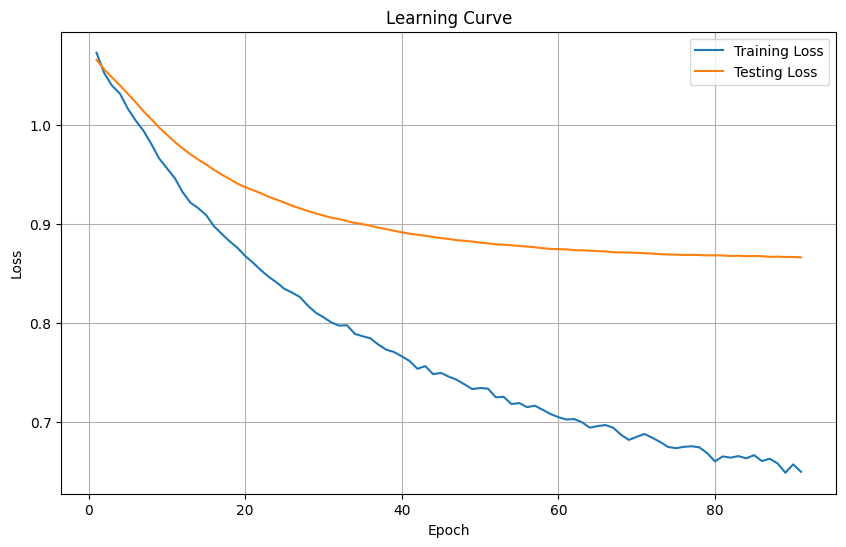

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       452
           1       0.32      0.32      0.32        69
           2       0.30      0.63      0.41        51

    accuracy                           0.73       572
   macro avg       0.51      0.58      0.53       572
weighted avg       0.78      0.73      0.75       572



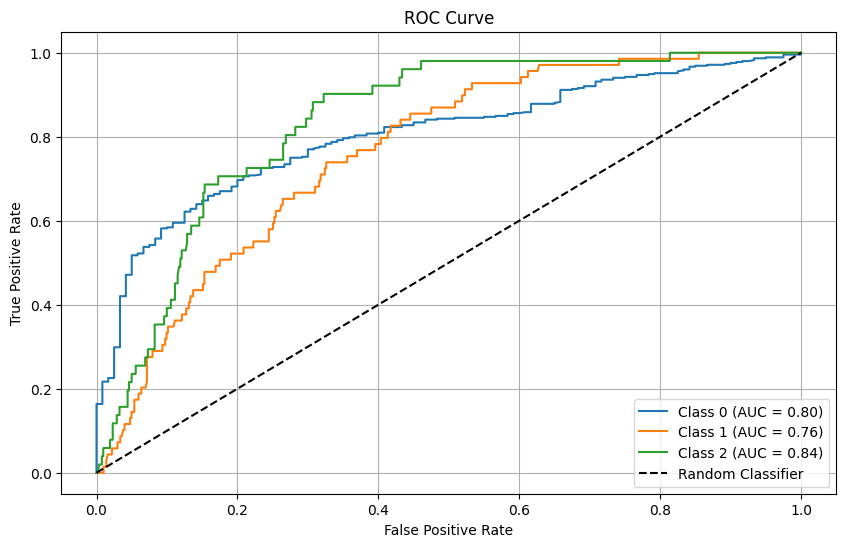

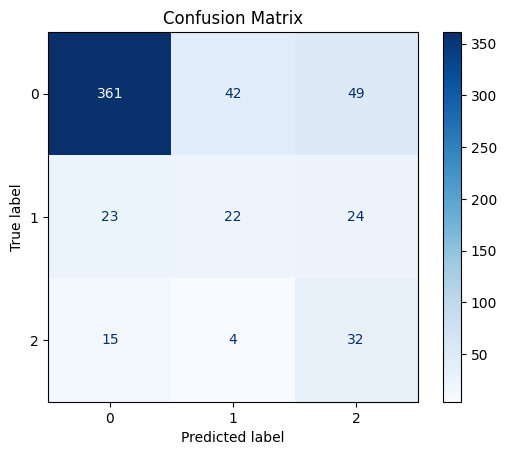

In [8]:
# Create a generator on CUDA
generator = torch.Generator(device="cuda")

class_weights_tensor = torch.tensor([0.10740779, 0.41708298, 0.69199618], dtype= torch.float32, device = device)

criterion= nn.CrossEntropyLoss(weight= class_weights_tensor)
optimizer= optim.Adagrad(model.parameters(), lr=0.0030754135797064503)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)  # Batch size adjustable
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)
epochs= 91
model_train(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, epochs=epochs)
evaluate_model(model, test_loader)